In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

In [2]:
# Assuming your data is already loaded into df and cleaned
# Load CSV file, skip the header, and manually assign column names
df = pd.read_csv("../source_coin_data/coinbaseUSD_1-min_data.csv", header=0)
df = df[-100000:]
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
df = df.drop(['Symbol', 'Unix Timestamp'], axis=1)
df.rename(columns={
    "Open":"open",
    "High":"high",
    "Low":"low",
    "Close":"close",
    "Volume":"volume"
}, inplace=True)

            open      high       low     close    volume
open    1.000000  0.999975  0.999971  0.999956 -0.067139
high    0.999975  1.000000  0.999955  0.999977 -0.064231
low     0.999971  0.999955  1.000000  0.999976 -0.070841
close   0.999956  0.999977  0.999976  1.000000 -0.067528
volume -0.067139 -0.064231 -0.070841 -0.067528  1.000000


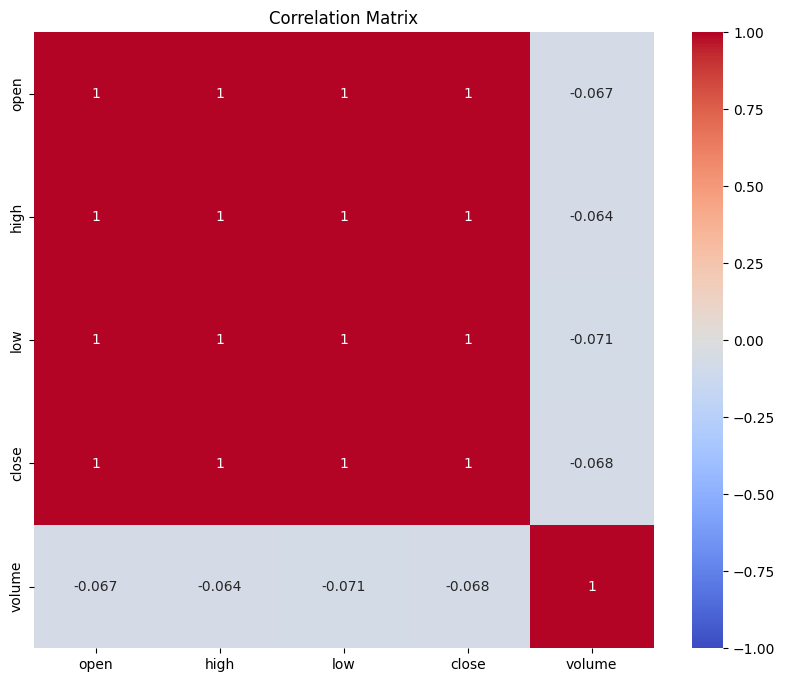

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called 'df'
# df = pd.read_csv('your_data.csv')  # or however you load your data

# Calculate the correlation matrix
correlation_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()

print(correlation_matrix)
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [4]:
# Ensure all numerical columns are in the correct format (float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

In [5]:
# Technical indicators
df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)
# df['RSI'] = ta.rsi(df.close, length=16)
my_bbands = ta.bbands(df.close, length=14, std=2.0)
df = df.join(my_bbands)

test_data = df[-50:]
df = df[50:-50]

C:\Users\Pc\AppData\Local\Temp\ipykernel_6908\1722955639.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)


In [6]:
from sklearn.preprocessing import MinMaxScaler
import joblib

df_numeric = df.select_dtypes(include=[np.number])

# Define a scaler for features (all columns)
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = feature_scaler.fit_transform(df_numeric)

# Save both scalers to use during prediction
joblib.dump(feature_scaler, 'feature_scaler_100K.joblib')




['feature_scaler_100K.joblib']

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Припустимо, що у вас є датасет з 7 ознак, включаючи "close"
seq_length = 100
pred_length = 5

# Створюємо функцію для підготовки послідовностей
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])  # 50 рядків для навчання
        y.append(data[i+seq_length:i+seq_length+pred_length, 3])  # Прогнозуємо "close" (індекс 3)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length, pred_length)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2

# import numpy as np
# import tensorflow as tf
# from sklearn.preprocessing import MinMaxScaler

# # Припустимо, що у вас є датасет з 7 ознак, включаючи "close"
# seq_length = 50
# pred_length = 5
l2_value = 0.0005

# # Створюємо функцію для підготовки послідовностей
# def create_sequences(data, seq_length, pred_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length - pred_length + 1):
#         X.append(data[i:i+seq_length])  # 50 рядків для навчання
#         y.append(data[i+seq_length:i+seq_length+pred_length, 3])  # Прогнозуємо "close" (індекс 3)
#     return np.array(X), np.array(y)

# X, y = create_sequences(scaled_data, seq_length, pred_length)

# Кастомна функція втрат (MSE між двома векторами з 5 елементів)
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return mse

# Build an enhanced LSTM model with L2 regularization
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2]), 
                            kernel_regularizer=l2(l2_value)),
    tf.keras.layers.LSTM(50, kernel_regularizer=l2(l2_value)),
    tf.keras.layers.Dense(pred_length)
])

# Compile model with custom loss and EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])
# # Predict on last sequence for evaluation
# last_sequence = X[-1]  # Last sequence for prediction
# predicted_close = model.predict(last_sequence[np.newaxis, :, :])

# # Scale back to original values for interpretability
# predicted_close = scaler.inverse_transform(predicted_close.flatten().reshape(-1, 1)).flatten()

# # Display results
# print("Прогнозовані 5 значень 'close':", predicted_close)
# print("Реальні 5 значень 'close':", df['close'].values[-5:])

Epoch 1/20
4993/4993 [==============================] - 77s 14ms/step - loss: 0.0034 - val_loss: 1.6813e-04
Epoch 2/20
4993/4993 [==============================] - 66s 13ms/step - loss: 1.8790e-04 - val_loss: 1.1607e-04
Epoch 3/20
4993/4993 [==============================] - 66s 13ms/step - loss: 1.3957e-04 - val_loss: 1.4934e-04
Epoch 4/20
4993/4993 [==============================] - 66s 13ms/step - loss: 1.1543e-04 - val_loss: 9.0114e-05
Epoch 5/20
4993/4993 [==============================] - 66s 13ms/step - loss: 9.3111e-05 - val_loss: 1.4324e-04
Epoch 6/20
4993/4993 [==============================] - 66s 13ms/step - loss: 7.9140e-05 - val_loss: 6.7005e-05
Epoch 7/20
4993/4993 [==============================] - 66s 13ms/step - loss: 8.9123e-05 - val_loss: 8.9567e-05
Epoch 8/20
4993/4993 [==============================] - 66s 13ms/step - loss: 7.1105e-05 - val_loss: 5.4443e-05
Epoch 9/20
4993/4993 [==============================] - 66s 13ms/step - loss: 6.2882e-05 - val_loss: 5.1038e

In [ ]:
model.save_weights("09_10_lstm_model_weights.h5")

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

# Create the prediction model
def create_prediction_model(seq_length, features):
    model = Sequential()
    model.add(LSTM(50, stateful=True, batch_input_shape=(1, seq_length, features), return_sequences=True))  # Batch size = 1 for prediction
    model.add(LSTM(50, stateful=True))
    model.add(Dense(5))  # Predicting the next 5 'close' values
    return model

# Initialize the prediction model
predict_model = create_prediction_model(seq_length, X.shape[2])

# Load the weights from the training model
predict_model.load_weights("09_10_lstm_model_weights.h5")

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

seq_length = 50  # Length of input sequences
pred_length = 5  # Number of values to predict
features = X.shape[2]

In [ ]:
import numpy as np
import joblib

# Завантаження скейлера
feature_scaler = joblib.load('feature_scaler.joblib')

# Підготовка останньої послідовності для прогнозування
last_50_rows = test_data[:-5].values
scaled_last_50_rows = feature_scaler.transform(last_50_rows)

# Перетворення у формат, очікуваний моделлю
last_sequence = scaled_last_50_rows[np.newaxis, :, :]  # Shape: (1, 50, number_of_features)

# Прогнозування
predicted_close = predict_model.predict(last_sequence)
predicted_close = predicted_close.flatten()


# Створення масиву з нулями для всіх ознак, крім 'close'
num_features = test_data.shape[1]
temp_array = np.zeros((len(predicted_close), num_features))
temp_array[:, 3] = predicted_close  # Припускаємо, що 'close' - останній стовпець

# Зворотне перетворення
inverse_transformed = feature_scaler.inverse_transform(temp_array)

# Вилучення лише значень 'close'
predicted_close_actual = inverse_transformed[:, 3]

print("Прогнозовані 5 значень 'close' (після зворотного перетворення):", predicted_close_actual)
print("Реальні 5 значень 'close':", test_data['close'].values[-5:])